In [3]:
import pdfplumber
import pandas
import numpy
import json

# 1. Get the document

You can get the document from this page : [Thesaurus des interactions médicamenteuses](https://ansm.sante.fr/documents/reference/thesaurus-des-interactions-medicamenteuses-1)

In [4]:
pdf = pdfplumber.open("thesaurus.pdf")

pages = pdf.pages

# 2. Extracting

In [5]:
example_page = 227
resolution = 100

## Extract two columns content

Two columns content contains the description of the interaction.


We define the following settings :

In [6]:
settings_two_columns = {
    # Use only lines defined in "explicit_vertical_lines"
    "vertical_strategy": "explicit",  
    # Use only lines defined in the document and "explicit_horizontal_lines"
    "horizontal_strategy": "lines",  
    # Explicitly specify the left, center, and right boundaries of each column (the document is poorly formated)
    "explicit_vertical_lines": [
        25,
        310,
        560,
    ],
    # Explicitly specify the top and bottom boundaries of each row
    "explicit_horizontal_lines": [
        820
    ],  # Explicitly specify the top and bottom boundaries of each row
    "intersection_x_tolerance": 300,
}

### Example

In [7]:
pandas.DataFrame(pages[example_page].extract_table(table_settings=settings_two_columns), columns=["left", "right"])


,left,right
0,+ZINC,
1,Diminution de l'absorption digestive du stront...,Précaution d'emploi\nPrendre le strontium à di...
2,SUBSTANCES À ABSORPTION RÉDUITE PAR LES TOPIQU...,"ES GASTRO-INTESTINAUX, ANTIACIDES ET\nandroniq..."
3,"+TOPIQUES GASTRO-INTESTINAUX, ANTIACIDES ET AD...",
4,Diminution de l'absorption de ces substances.,ASDEC - PE\nAssociation déconseillée:\n- avec ...
5,SUBSTANCES SUSCEPTIBLES DE DONNER DES TORSAD\n...,"ES DE POINTES\ncaments, antiarythmiques ou non..."
6,,
7,+ANAGRELIDE,
8,Risque majoré de troubles du rythme ventricula...,Précaution d'emploi\nSurveillance clinique et ...
9,+ANTIPARASITAIRES SUSCEPTIBLES DE DONNER DES T...,POINTES


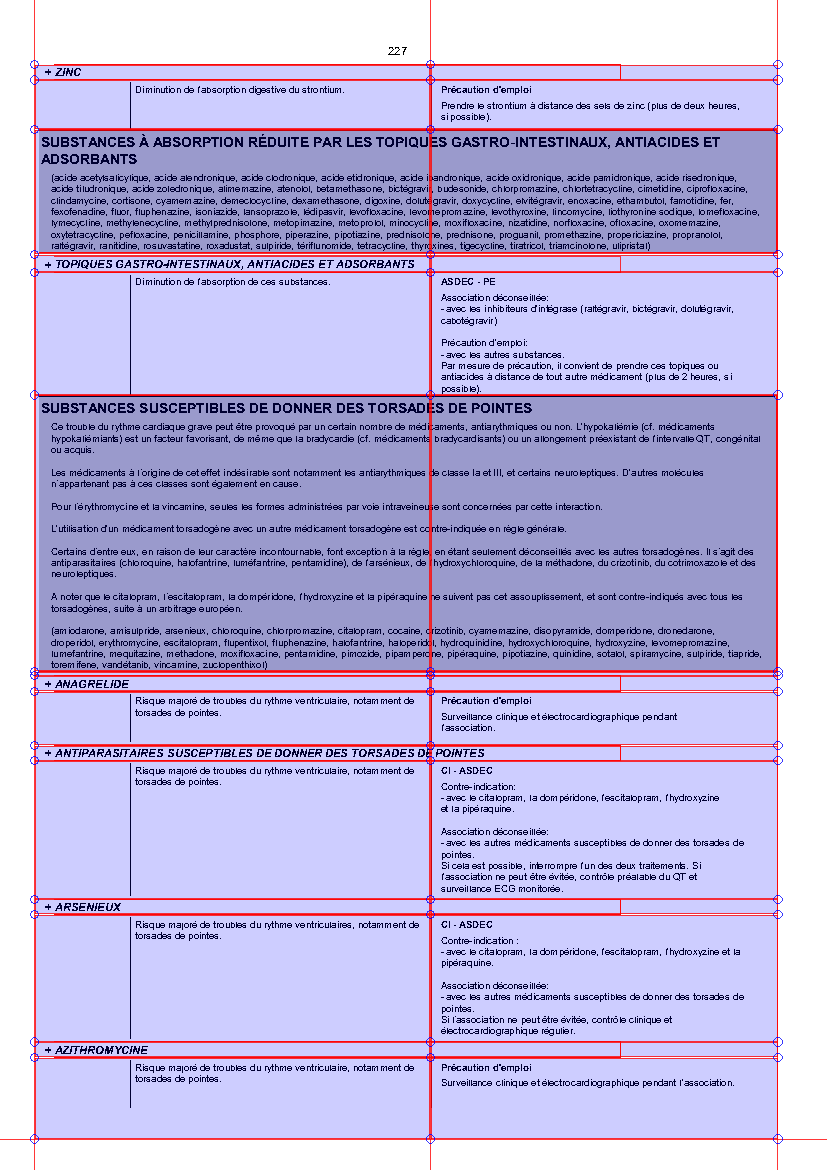

In [8]:
pages[example_page].to_image(resolution=resolution).debug_tablefinder(table_settings=settings_two_columns)

## Extractions of one column content 

In [9]:
settings_single_column = {
    # Use only lines defined in "explicit_vertical_lines"
    "vertical_strategy": "explicit",
    # Use only lines defined in the document and "explicit_horizontal_lines"
    "horizontal_strategy": "lines",
    # Explicitly specify the left, right boundaries of the column / table.
    "explicit_vertical_lines": [25, 560],
    # Explicitly specify the top and bottom boundaries of each table.
    "explicit_horizontal_lines": [820],
    # Set text to be split if the distance between two letters is greater than 5
    "intersection_x_tolerance": 300,
}

### Example

In [10]:
pandas.DataFrame(pages[example_page].extract_table(table_settings=settings_single_column))

,0
0,+ZINC
1,Diminution de l'absorption digestive du stront...
2,SUBSTANCES À ABSORPTION RÉDUITE PAR LES TOPIQU...
3,"+TOPIQUES GASTRO-INTESTINAUX, ANTIACIDES ET AD..."
4,Diminution de l'absorption de ces substances. ...
5,SUBSTANCES SUSCEPTIBLES DE DONNER DES TORSADES...
6,
7,+ANAGRELIDE
8,Risque majoré de troubles du rythme ventricula...
9,+ANTIPARASITAIRES SUSCEPTIBLES DE DONNER DES T...


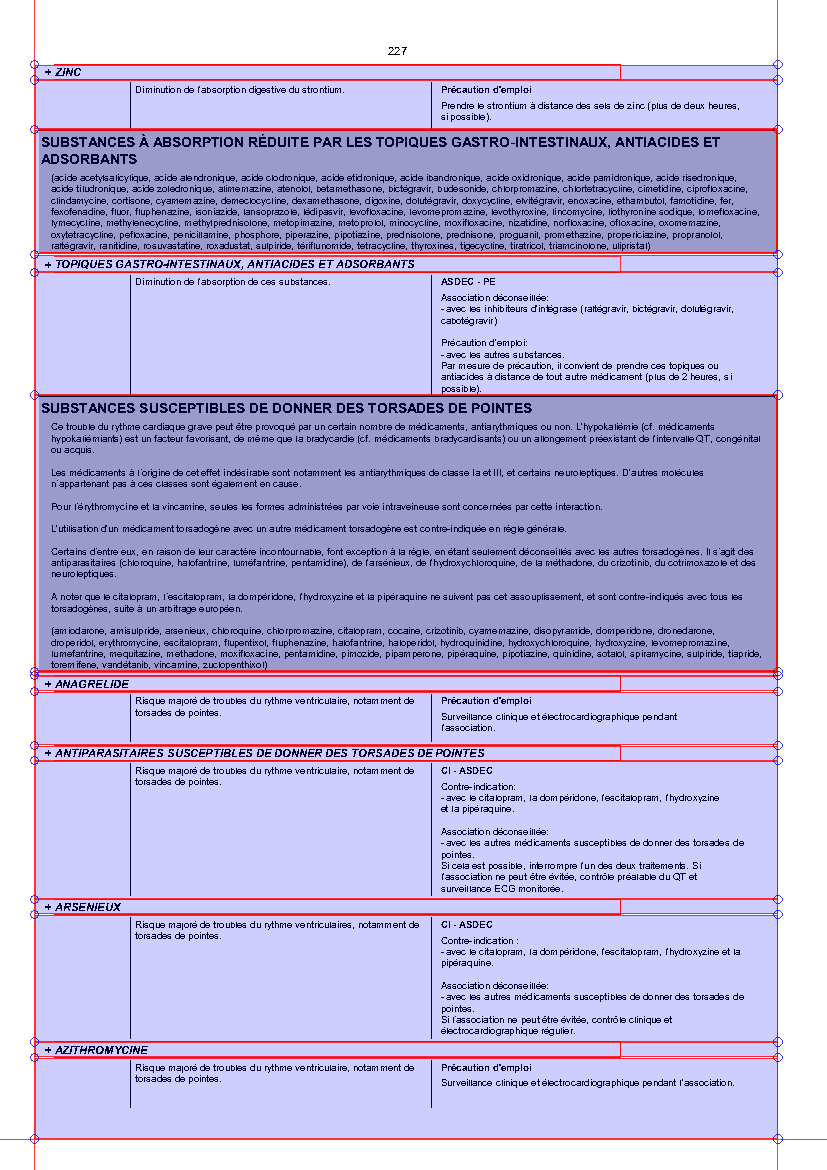

In [11]:
pages[example_page].to_image(resolution=resolution).debug_tablefinder(table_settings=settings_single_column)


### All

In [12]:
pages_number = numpy.arange(2, len(pages))

single_column_tables = []
for i in pages_number:
    print(f"Substance extraction page {i} / {len(pages) - 1}", end="\r", flush=True)
    single_column_tables.extend(pages[i].extract_table(settings_single_column))

print("")

two_column_tables = []
for i in pages_number:
    print(f"Description extraction page {i} / {len(pages) - 1}", end="\r", flush=True)
    two_column_tables.extend(pages[i].extract_table(settings_two_columns))

print(f"\n{len(single_column_tables)} substances extracted")

Substance extraction page 262 / 262
Description extraction page 262 / 262
7138 substances extracted


# 4. Formatting

We identified the following patterns :
- Interactions begin with a `+` character (and is in uppercase) : `+ANTISEPTIQUES MERCURIELS`
- All substances are in uppercase, e.g. `POVIDONE IODÉE`
- The substance description, if any, follows the substance name after a line break `\n`.
- Everything else is a description of the interaction.

From this, we can format the tables as a JSON in the following format :

```json
[
    {
        "name": "SUBSTANCE",
        "description": "Description of the substance",
        "interactions": [
            {
                "name": "INTERACTION 1",
                "effect": "Effect of the interaction",
                "advise": "Some advice",
                "type": [
                    "The type of interaction"
                ]
            },
            {
                "...": "..."
            }
        ]
    },
    {
        "...": "..."
    }
]
```

In [13]:
# Since our table extraction rely on the fact that the two lists index correspond to the same substance, we need to check if the lists have the same length
assert len(single_column_tables) == len(two_column_tables)

output = []

current_interaction = {}
current_substance = {}


def format_description(string):
    string = string.replace("\n", " ")
    return string


for i in range(len(single_column_tables)):
    both = single_column_tables[i][0].split("\n", 1)

    left = two_column_tables[i][0]
    right = two_column_tables[i][1]

    

    # Identify new interaction (col0 starts with "+")
    if both[0].startswith("+"):
        if not current_substance:
            continue

        # Append the last interaction to the current substance
        if current_interaction:
            current_substance["interactions"].append(current_interaction)
        # Set new current interaction
        name = both[0].replace("+", "").strip()
        current_interaction = {
            "name": name,
            "effect": "",
            "advise": "",
            "type": "",
        }

        continue


    if both[0].isupper():
        # Append current substance to output
        if current_substance:
            if current_interaction:
                current_substance["interactions"].append(current_interaction)
                current_interaction = {}
            output.append(current_substance)

        name = both[0].strip()
        description = ""
        if len(both) > 1:
            description = both[1].replace("\n", " ")

        # Reset interaction and substance
        current_substance = {
            "name": name,
            "description": description,
            "interactions": [],
        }
        continue

    # If we're inside an interaction, append description
    if current_interaction:

        current_interaction["effect"] += format_description(left) + " "

        if current_interaction["type"] == "":
            split = right.split("\n", 1)

            type = split[0].split(" - ")

            current_interaction["type"] = type
            if len(split) > 1:
                current_interaction["advise"] = format_description(split[1]) + " "
        else:
            current_interaction["advise"] += format_description(right) + " "

In [14]:
output[0]

{'name': 'ABATACEPT',
 'description': '',
 'interactions': [{'name': 'ANTI-TNF ALPHA',
   'effect': 'Majoration de l’immunodépression. ',
   'advise': '',
   'type': ['Association DECONSEILLEE']},
  {'name': 'VACCINS VIVANTS ATTÉNUÉS',
   'effect': 'Risque de maladie vaccinale généralisée, éventuellement mortelle. ',
   'advise': "ainsi que pendant les 3 mois suivant l'arrêt du traitement. ",
   'type': ['Association DECONSEILLEE']}]}

# 5. Exporting

In [15]:
with open("output.json", "w", encoding="utf-8") as file:
    dump = json.dumps(output, indent=4, ensure_ascii=False)
    file.write(dump)